Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import lightning.pytorch as pl

from sklearn.metrics import mean_squared_error, mean_absolute_error

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import RMSE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


Loading the dataset

In [3]:
INPUT_CSV = "C:/Users/User/Downloads/Master file.csv"

Setting up environment and global configuration

In [4]:
#Basic Configuration
DATE_COL   = "Date"
GROUP_COL  = "RegionName"
HPI_LEVEL  = "Index"       
TARGET_COL = "HPI_TRANS"   

max_encoder_length    = 36   
max_prediction_length = 1     

split_date = pd.Timestamp("2018-01-01")  

# Predictor variables 
PREDICTOR_VARS = [
    # Traditional macro
    "AWE_Regular",
    "UnemploymentRate",
    "CPI",
    "MortgageApprovals",
    "MortgageRate_2YFix",
    "BankRate",
    "ConsumerConfidence",
    "BM_New Housing",

    # High-frequency Google Trends theme indices
    "gt_trend_buying_demand",
    "gt_trend_economic_policy",
    "gt_trend_market_awareness",
    "gt_trend_mortgage_financing",
    "gt_trend_renting_affordability",

    # GDELT tone
    "AvgTone_Stitched",
]

In [5]:
#Loading the dataset
print("Loading data from:", INPUT_CSV)
df = pd.read_csv(INPUT_CSV)

# Converting Date column to DateTime
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

# Sorting by region and date
df = df.sort_values([GROUP_COL, DATE_COL]).reset_index(drop=True)

# Converting the target variable to log transformation
df[TARGET_COL] = (
    df.groupby(GROUP_COL)[HPI_LEVEL]
      .transform(lambda s: np.log(s).diff())
)

# Dropping null rows after differencing
df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

# Forward-filling of BM_Housing to deal with missing values from Feb 2025 to June 2025
if "BM_New Housing" in df.columns:
    df = df.sort_values([GROUP_COL, DATE_COL])
    df["BM_New Housing"] = df.groupby(GROUP_COL)["BM_New Housing"].ffill()
    df["BM_New Housing"] = df.groupby(GROUP_COL)["BM_New Housing"].bfill()

# Creating time index
df = df.sort_values([GROUP_COL, DATE_COL])
df["time_idx"] = (
    (df[DATE_COL].dt.year - df[DATE_COL].dt.year.min()) * 12
    + (df[DATE_COL].dt.month - 1)
)

print("Data span:", df[DATE_COL].min(), "→", df[DATE_COL].max())
print("Regions:", df[GROUP_COL].nunique())
print("Columns:", df.columns.tolist())



Loading data from: C:/Users/User/Downloads/Master file.csv
Data span: 2005-02-01 00:00:00 → 2025-06-01 00:00:00
Regions: 405
Columns: ['Date', 'RegionName', 'AreaCode', 'AveragePrice', 'Index', 'SalesVolume', 'AWE_Total', 'AWE_Regular', 'UnemploymentRate', 'CPI', 'MortgageApprovals', 'MortgageRate_2YFix', 'BankRate', 'ConsumerConfidence', 'BM_New Housing', 'gt_trend_buying_demand', 'gt_trend_economic_policy', 'gt_trend_market_awareness', 'gt_trend_mortgage_financing', 'gt_trend_renting_affordability', 'AvgTone_Stitched', 'Docs_Stitched', 'Source', 'HPI_TRANS', 'time_idx']


Train-Test Split

In [6]:
#Train-test split
df_train = df[df[DATE_COL] < split_date].copy()
df_test  = df[df[DATE_COL] >= split_date].copy()

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

Train shape: (62775, 25)
Test shape : (36450, 25)


Creating Training, Validation, and Test timeseries dataset

In [7]:
max_train_time = df_train["time_idx"].max()
val_boundary   = max_train_time - 24
print("Validation boundary time_idx:", val_boundary)

continuous_features = PREDICTOR_VARS.copy()

# Training dataset
train_dataset = TimeSeriesDataSet(
    df_train[df_train.time_idx <= val_boundary],
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[GROUP_COL],

    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    time_varying_unknown_reals=[TARGET_COL] + continuous_features,
    time_varying_known_reals=[],
    static_categoricals=[GROUP_COL],
)

# Validation dataset
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df_train,
    predict=True,
    stop_randomization=True,
)

# Test dataset  
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df_test,
    predict=False,        
    stop_randomization=True,
)

print("Train samples:", len(train_dataset))
print("Val samples  :", len(val_dataset))
print("Test samples :", len(test_dataset))


Validation boundary time_idx: 131
Train samples: 38475
Val samples  : 405
Test samples : 21870


Creating Data Loaders for training, validation, and test datasets

In [8]:
batch_size = 64
#Data Loaders
train_loader = train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0,
)

val_loader = val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

test_loader = test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))


Train batches: 601
Val batches  : 7
Test batches : 342


In [9]:
print("Train dataset length:", len(train_loader.dataset))
print("Val dataset length:", len(val_loader.dataset))


Train dataset length: 38475
Val dataset length: 405


Defining the Temporal Fusion Transformer model

In [9]:
import torch

pl.seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    output_size=1,
    loss=RMSE(),
    reduce_on_plateau_patience=4,
)

print(f"TFT parameters: {tft.size()/1e3:.1f}k")


Seed set to 42
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Using device: cpu
TFT parameters: 335.6k


Configuring callbacks and initialising training

In [10]:
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="min",
    verbose=True,
)

lr_logger = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    callbacks=[early_stop_callback, lr_logger],
    gradient_clip_val=0.1,
    log_every_n_steps=50,
)

trainer.fit(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

   | Name                               | Type                            | Params | Mode 
----------------------------------------------------------------------------------------

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.012


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.011. Signaling Trainer to stop.


Generation of test forecast and performance evaluation

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#  Prediction on the test set
test_results_base = tft.predict(test_loader, return_index=True)

y_pred_base = test_results_base.output.detach().cpu().numpy().flatten()
idx_df_base = test_results_base.index.copy()
idx_df_base["y_pred_base"] = y_pred_base

# Merging the predictions back into full df
df_merged_base = df.merge(
    idx_df_base,
    on=[GROUP_COL, "time_idx"],
    how="inner",
)

df_eval_base = df_merged_base[df_merged_base[DATE_COL] >= split_date].copy()
df_eval_base["y_true"]      = df_eval_base[TARGET_COL]
df_eval_base["pct_true"]    = df_eval_base["y_true"] * 100
df_eval_base["pct_pred_b"]  = df_eval_base["y_pred_base"] * 100
df_eval_base["error_base"]  = df_eval_base["pct_pred_b"] - df_eval_base["pct_true"]

# Panel (regional) metrics
rmse_panel_base = np.sqrt(mean_squared_error(df_eval_base["y_true"], df_eval_base["y_pred_base"]))
mae_panel_base  = mean_absolute_error(df_eval_base["y_true"], df_eval_base["y_pred_base"])

print("=== Baseline TFT Panel (regional) performance ===")
print("RMSE (Δlog):", rmse_panel_base)
print("MAE  (Δlog):", mae_panel_base)
print("≈ RMSE (%):", rmse_panel_base * 100)
print("≈ MAE  (%):", mae_panel_base * 100)

# UK-level aggregation
df_uk_base = (
    df_eval_base.groupby(DATE_COL)
                .agg(
                    uk_true=("pct_true", "mean"),
                    uk_pred_base=("pct_pred_b", "mean"),
                )
                .reset_index()
)

rmse_uk_base = np.sqrt(mean_squared_error(df_uk_base["uk_true"], df_uk_base["uk_pred_base"]))
mae_uk_base  = mean_absolute_error(df_uk_base["uk_true"], df_uk_base["uk_pred_base"])

print("\n=== Baseline TFT UK-aggregated performance ===")
print("Baseline TFT UK RMSE (%):", rmse_uk_base)
print("Baseline TFT UK MAE  (%):", mae_uk_base)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


=== Baseline TFT Panel (regional) performance ===
RMSE (Δlog): 0.016944892983803254
MAE  (Δlog): 0.012714940935373899
≈ RMSE (%): 1.6944892983803255
≈ MAE  (%): 1.27149409353739

=== Baseline TFT UK-aggregated performance ===
Baseline TFT UK RMSE (%): 1.0059381307528914
Baseline TFT UK MAE  (%): 0.8688887045963137


Variable Importance Analysis

In [15]:
from pytorch_forecasting import TemporalFusionTransformer

best_tft = TemporalFusionTransformer.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
print("Best model checkpoint:", trainer.checkpoint_callback.best_model_path)

C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Best model checkpoint: C:\Users\User\Documents\Deep learning\lightning_logs\version_10\checkpoints\epoch=12-step=7813.ckpt


In [17]:
# Variable importance analysis

# Raw predictions on validation set 
val_results_base = best_tft.predict(
    val_loader,
    mode="raw",
    return_x=True,
)

interpretation_base = best_tft.interpret_output(
    val_results_base.output,
    reduction="sum",   
)

# Encoder variable importance
enc_imp_base = interpretation_base["encoder_variables"].detach().cpu().numpy()
enc_names_base = best_tft.encoder_variables

print("Baseline TFT – Encoder variable importance:")
for name, score in zip(enc_names_base, enc_imp_base):
    print(f"{name}: {score:.4f}")

# Static variable importance
static_imp_base = interpretation_base["static_variables"].detach().cpu().numpy()
static_names_base = best_tft.static_variables

print("\nBaseline TFT – Static variable importance:")
for name, score in zip(static_names_base, static_imp_base):
    print(f"{name}: {score:.4f}")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Baseline TFT – Encoder variable importance:
HPI_TRANS: 55.9918
AWE_Regular: 37.4328
UnemploymentRate: 27.9604
CPI: 24.0921
MortgageApprovals: 73.0189
MortgageRate_2YFix: 16.2476
BankRate: 5.4774
ConsumerConfidence: 17.0761
BM_New Housing: 20.6585
gt_trend_buying_demand: 18.7777
gt_trend_economic_policy: 51.1292
gt_trend_market_awareness: 29.2193
gt_trend_mortgage_financing: 10.6469
gt_trend_renting_affordability: 14.3291
AvgTone_Stitched: 2.9421

Baseline TFT – Static variable importance:
RegionName: 405.0000


Plotting Actual vs Predicted change in monthly HPI at UK-level

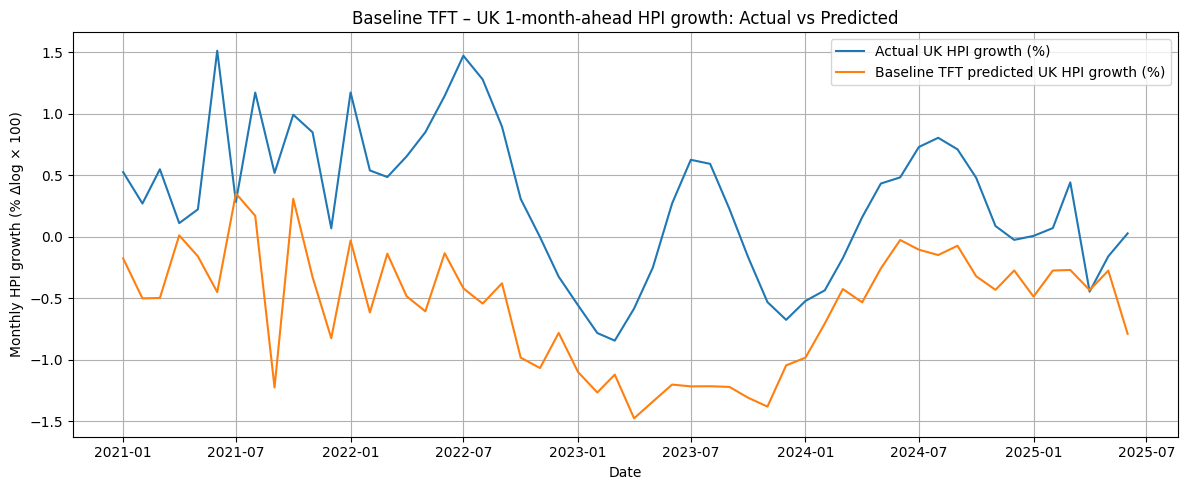

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(df_uk_base["Date"], df_uk_base["uk_true"], label="Actual UK HPI growth (%)")
plt.plot(df_uk_base["Date"], df_uk_base["uk_pred_base"], label="Baseline TFT predicted UK HPI growth (%)")

plt.title("Baseline TFT – UK 1-month-ahead HPI growth: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Monthly HPI growth (% Δlog × 100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Calculation of Computational Efficiency

In [11]:
import time
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import RMSE

pl.seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

#TFT model

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    output_size=1,   
    loss=RMSE(),           
    reduce_on_plateau_patience=4,
)

print(f"TFT parameters: {tft.size()/1e3:.1f}k")

#  Callbacks / Trainer
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="min",
    verbose=True,
)

lr_logger = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",     
    callbacks=[early_stop_callback, lr_logger],
    gradient_clip_val=0.1,
    log_every_n_steps=50,
)


# Measuring Training time

t_train_start = time.time()

trainer.fit(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

t_train_end = time.time()
tft_train_time = t_train_end - t_train_start
print(f"\n=== TFT Computational Efficiency: Training ===")
print(f"Total TFT training time: {tft_train_time:.2f} seconds "
      f"({tft_train_time/60:.2f} minutes)")


Seed set to 42


Using device: cpu


C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from 

TFT parameters: 335.6k


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.012


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.011. Signaling Trainer to stop.



=== TFT Computational Efficiency: Training ===
Total TFT training time: 4018.05 seconds (66.97 minutes)


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import time

# Measuring Prediction time
t_pred_start = time.time()

# Predicting on the test set
test_results_base = tft.predict(test_loader, return_index=True)

t_pred_end = time.time()
tft_pred_time = t_pred_end - t_pred_start

print(f"\n=== TFT Computational Efficiency: Prediction ===")
print(f"Total TFT prediction time on test set: {tft_pred_time:.4f} seconds")

#Evaluation metrics
y_pred_base = test_results_base.output.detach().cpu().numpy().flatten()
idx_df_base = test_results_base.index.copy()
idx_df_base["y_pred_base"] = y_pred_base

# Merge predictions back into full df
df_merged_base = df.merge(
    idx_df_base,
    on=[GROUP_COL, "time_idx"],
    how="inner",
)

df_eval_base = df_merged_base[df_merged_base[DATE_COL] >= split_date].copy()
df_eval_base["y_true"]      = df_eval_base[TARGET_COL]
df_eval_base["pct_true"]    = df_eval_base["y_true"] * 100
df_eval_base["pct_pred_b"]  = df_eval_base["y_pred_base"] * 100
df_eval_base["error_base"]  = df_eval_base["pct_pred_b"] - df_eval_base["pct_true"]

# Panel metrics
rmse_panel_base = np.sqrt(mean_squared_error(df_eval_base["y_true"], df_eval_base["y_pred_base"]))
mae_panel_base  = mean_absolute_error(df_eval_base["y_true"], df_eval_base["y_pred_base"])

print("\n=== Baseline TFT Panel (regional) performance ===")
print("RMSE (Δlog):", rmse_panel_base)
print("MAE  (Δlog):", mae_panel_base)
print("≈ RMSE (%):", rmse_panel_base * 100)
print("≈ MAE  (%):", mae_panel_base * 100)

# UK-level aggregation
df_uk_base = (
    df_eval_base.groupby(DATE_COL)
                .agg(
                    uk_true=("pct_true", "mean"),
                    uk_pred_base=("pct_pred_b", "mean"),
                )
                .reset_index()
)

rmse_uk_base = np.sqrt(mean_squared_error(df_uk_base["uk_true"], df_uk_base["uk_pred_base"]))
mae_uk_base  = mean_absolute_error(df_uk_base["uk_true"], df_uk_base["uk_pred_base"])

print("\n=== Baseline TFT UK-aggregated performance ===")
print("Baseline TFT UK RMSE (%):", rmse_uk_base)
print("Baseline TFT UK MAE  (%):", mae_uk_base)

# Per-observation prediction time

n_obs_test = len(df_eval_base)
print(f"\nTFT prediction time per observation: "
      f"{tft_pred_time / n_obs_test:.6f} seconds "
      f"(N = {n_obs_test} test observations)")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



=== TFT Computational Efficiency: Prediction ===
Total TFT prediction time on test set: 42.9502 seconds

=== Baseline TFT Panel (regional) performance ===
RMSE (Δlog): 0.016944892983803254
MAE  (Δlog): 0.012714940935373899
≈ RMSE (%): 1.6944892983803255
≈ MAE  (%): 1.27149409353739

=== Baseline TFT UK-aggregated performance ===
Baseline TFT UK RMSE (%): 1.0059381307528914
Baseline TFT UK MAE  (%): 0.8688887045963137

TFT prediction time per observation: 0.001964 seconds (N = 21870 test observations)


Hyperpramater tuning of the TFT model

In [2]:
# Importing of required libraries
import pandas as pd
import numpy as np
import torch
import lightning.pytorch as pl

from sklearn.metrics import mean_squared_error, mean_absolute_error

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import RMSE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Setting up environment and Global Configuration

In [3]:
pl.seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Basic configuration
INPUT_CSV = "C:/Users/User/Downloads/Master file.csv"
DATE_COL   = "Date"
GROUP_COL  = "RegionName"
HPI_LEVEL  = "Index"
TARGET_COL = "HPI_TRANS"

max_encoder_length    = 48    
max_prediction_length = 1
split_date = pd.Timestamp("2018-01-01")

PREDICTOR_VARS = [
    "AWE_Regular",
    "UnemploymentRate",
    "CPI",
    "MortgageApprovals",
    "MortgageRate_2YFix",
    "BankRate",
    "ConsumerConfidence",
    "BM_New Housing",
    "gt_trend_buying_demand",
    "gt_trend_economic_policy",
    "gt_trend_market_awareness",
    "gt_trend_mortgage_financing",
    "gt_trend_renting_affordability",
    "AvgTone_Stitched",
]

Seed set to 42


Using device: cpu


In [4]:
#Loading the dataset
print("Loading data from:", INPUT_CSV)
df = pd.read_csv(INPUT_CSV)

# Converting Date column to DateTime
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values([GROUP_COL, DATE_COL]).reset_index(drop=True)

# Converting the target variable to log transformation
df[TARGET_COL] = (
    df.groupby(GROUP_COL)[HPI_LEVEL]
      .transform(lambda s: np.log(s).diff())
)

# Dropping null rows after differencing
df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

# Forward-filling of BM_Housing to deal with missing values from Feb 2025 to June 2025
if "BM_New Housing" in df.columns:
    df = df.sort_values([GROUP_COL, DATE_COL])
    df["BM_New Housing"] = df.groupby(GROUP_COL)["BM_New Housing"].ffill()
    df["BM_New Housing"] = df.groupby(GROUP_COL)["BM_New Housing"].bfill()

# Creating time index
df = df.sort_values([GROUP_COL, DATE_COL])
df["time_idx"] = (
    (df[DATE_COL].dt.year - df[DATE_COL].dt.year.min()) * 12
    + (df[DATE_COL].dt.month - 1)
)

print("Data span:", df[DATE_COL].min(), "→", df[DATE_COL].max())
print("Regions:", df[GROUP_COL].nunique())

# Train-test split
df_train = df[df[DATE_COL] < split_date].copy()
df_test  = df[df[DATE_COL] >= split_date].copy()

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)


Loading data from: C:/Users/User/Downloads/Master file.csv
Data span: 2005-02-01 00:00:00 → 2025-06-01 00:00:00
Regions: 405
Train shape: (62775, 25)
Test shape : (36450, 25)


In [5]:
max_train_time = df_train["time_idx"].max()
val_boundary   = max_train_time - 24
print("Validation boundary time_idx:", val_boundary)

continuous_features = PREDICTOR_VARS.copy()

# Training dataset
train_dataset = TimeSeriesDataSet(
    df_train[df_train.time_idx <= val_boundary],
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[GROUP_COL],

    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    time_varying_unknown_reals=[TARGET_COL] + continuous_features,
    time_varying_known_reals=[],
    static_categoricals=[GROUP_COL],
)

# Validation dataset
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df_train,
    predict=True,
    stop_randomization=True,
)

# TEST dataset
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    df_test,
    predict=False,
    stop_randomization=True,
)

print("Train samples:", len(train_dataset))
print("Val samples  :", len(val_dataset))
print("Test samples :", len(test_dataset))


Validation boundary time_idx: 131
Train samples: 33615
Val samples  : 405
Test samples : 17010


In [6]:
# Data Loader Setup
batch_size = 128  
#Data Loaders
train_loader = train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0,
)

val_loader = val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

test_loader = test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))


Train batches: 262
Val batches  : 4
Test batches : 133


In [7]:
# Model configuration and Hyperparameter selection
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=5e-4,          
    hidden_size=128,             
    attention_head_size=4,
    dropout=0.05,                
    hidden_continuous_size=64,
    output_size=1,
    loss=RMSE(),
    reduce_on_plateau_patience=4,
    optimizer="adam",
    weight_decay=1e-4,           
)

print(f"TFT parameters: {tft.size()/1e3:.1f}k")


C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TFT parameters: 1241.7k


In [8]:
# Tuned Training Strategy and Callback Configuration for LSTM
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=15,
    mode="min",
    verbose=True,
)

lr_logger = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

trainer = pl.Trainer(
    max_epochs=150,
    accelerator="auto",
    callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
    gradient_clip_val=0.1,
    log_every_n_steps=50,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
# TFT Model training and Best Checkpoint Selection with tuned hyperparameters
trainer.fit(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

print("Best model path:", checkpoint_callback.best_model_path)



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 18.6 K | train
3  | prescalers                         | ModuleDict                      | 1.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 384    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 403 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K 

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.014


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.012


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.012. Signaling Trainer to stop.


Best model path: C:\Users\User\Documents\Deep learning\lightning_logs\version_17\checkpoints\epoch=6-step=1834.ckpt


In [12]:
# Post-tuning Forecast Generation and Evaluation metrics
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    checkpoint_callback.best_model_path
)

# Predictions on test dataset
test_results = best_tft.predict(test_loader, return_index=True)

y_pred = test_results.output.detach().cpu().numpy().flatten()
idx_df = test_results.index.copy()
idx_df["y_pred"] = y_pred

# Merging back to full df
df_merged = df.merge(
    idx_df,
    on=[GROUP_COL, "time_idx"],
    how="inner",
)

df_eval = df_merged[df_merged[DATE_COL] >= split_date].copy()
df_eval["y_true"]   = df_eval[TARGET_COL]
df_eval["pct_true"] = df_eval["y_true"] * 100
df_eval["pct_pred"] = df_eval["y_pred"] * 100
df_eval["error"]    = df_eval["pct_pred"] - df_eval["pct_true"]

rmse_global = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_pred"]))
mae_global  = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])

print("=== Panel (regional) performance ===")
print("TFT Test RMSE (Δlog):", rmse_global)
print("TFT Test MAE  (Δlog):", mae_global)
print("≈ TFT RMSE (%):", rmse_global * 100)
print("≈ TFT MAE (%):", mae_global * 100)

# UK-level aggregation
df_uk = (
    df_eval.groupby(DATE_COL)
           .agg(
               uk_true=("pct_true", "mean"),
               uk_pred=("pct_pred", "mean"),
           )
           .reset_index()
)

rmse_uk = np.sqrt(mean_squared_error(df_uk["uk_true"], df_uk["uk_pred"]))
mae_uk  = mean_absolute_error(df_uk["uk_true"], df_uk["uk_pred"])

print("\n=== UK-aggregated performance ===")
print("TFT UK-level RMSE (%):", rmse_uk)
print("TFT UK-level MAE  (%):", mae_uk)


C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does no

=== Panel (regional) performance ===
TFT Test RMSE (Δlog): 0.014684171319826841
TFT Test MAE  (Δlog): 0.01090210174671322
≈ TFT RMSE (%): 1.4684171319826842
≈ TFT MAE (%): 1.090210174671322

=== UK-aggregated performance ===
TFT UK-level RMSE (%): 0.6654577589172469
TFT UK-level MAE  (%): 0.5087257989466027


In [13]:
# Variable Importance Analysis after hyperparameter tuning
# Raw predictions on validation set
val_results = best_tft.predict(
    val_loader,
    mode="raw",
    return_x=True,
)

interpretation = best_tft.interpret_output(
    val_results.output,
    reduction="sum",
)

# Encoder variable importance
enc_imp = interpretation["encoder_variables"].detach().cpu().numpy()
enc_names = best_tft.encoder_variables

print("Encoder variable importance:")
for name, score in zip(enc_names, enc_imp):
    print(f"{name}: {score:.4f}")

# Static variable importance
static_imp = interpretation["static_variables"].detach().cpu().numpy()
static_names = best_tft.static_variables

print("\nStatic variable importance:")
for name, score in zip(static_names, static_imp):
    print(f"{name}: {score:.4f}")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Encoder variable importance:
HPI_TRANS: 90.7947
AWE_Regular: 16.1865
UnemploymentRate: 32.5215
CPI: 17.3257
MortgageApprovals: 5.9261
MortgageRate_2YFix: 11.7714
BankRate: 11.8075
ConsumerConfidence: 17.6478
BM_New Housing: 22.9962
gt_trend_buying_demand: 17.0476
gt_trend_economic_policy: 76.6473
gt_trend_market_awareness: 14.9213
gt_trend_mortgage_financing: 12.7634
gt_trend_renting_affordability: 17.9258
AvgTone_Stitched: 38.7174

Static variable importance:
RegionName: 405.0000
